## Step 1: Understanding the Problem

1. What are we forecasting?
    - Coins price.

2. It is multivariate!

3. What's the forecast horizon?
    - Next 4 hours,8 hours, ...

## Step 2: Load and Prepare the Data
- Load dataset

- Parse dates: make sure the time column is a datetime object.

- Set the date column as the index.

- Sort the data by time.

In [415]:
import pandas as pd
from pathlib import Path
import seaborn as sns
from utils import seasonal_plot,plot_periodogram

Data_directory = Path('Dataset')

Trainning_Set = pd.read_csv(
    Data_directory / 'train.csv',
    dtype={
        'open': 'float64',
        'high': 'float64',
        'low': 'float64',
        'close': 'float64',
        'volume': 'float64'
    }
)
print(Trainning_Set.columns)
Trainning_Set = Trainning_Set.sort_values("day_id").set_index("day_id")


Test_set =  pd.read_csv(
    Data_directory / 'test.csv',
    parse_dates=['day_id'])

Index(['day_id', 'open', 'high', 'low', 'close', 'volume'], dtype='object')


In [416]:
    # information about the training set
print("Training Set Info:")
print(Trainning_Set.info())

    # first few rows of the training set
print("\nFirst few rows of Training Set:")
print(Trainning_Set.head())

    # basic statistics of the training set
print("\nTraining Set Statistics:")
print(Trainning_Set.describe())

    # missing values in the training set
print("\nMissing Values in Training Set:")
print(Trainning_Set.isnull().sum())

    # basic information about the test set
print("\nTest Set Info:")
print(Test_set.info())

    # first few rows of the test set
print("\nFirst few rows of Test Set:")
print(Test_set.head())

    # missing values in the test set
print("\nMissing Values in Test Set:")
print(Test_set.isnull().sum())

Training Set Info:
<class 'pandas.core.frame.DataFrame'>
Index: 35040 entries, D0010000 to D3652345
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    35040 non-null  float64
 1   high    35040 non-null  float64
 2   low     35040 non-null  float64
 3   close   35040 non-null  float64
 4   volume  35040 non-null  float64
dtypes: float64(5)
memory usage: 1.6+ MB
None

First few rows of Training Set:
             open     high      low    close      volume
day_id                                                  
D0010000  0.61734  0.62018  0.61604  0.61649   8975.7253
D0010015  0.61914  0.62501  0.61577  0.61772  26506.5234
D0010030  0.61875  0.62204  0.61060  0.61168  17334.6429
D0010045  0.61104  0.61190  0.60207  0.60467  18324.3072
D0010100  0.60507  0.60560  0.59372  0.59451  23422.2065

Training Set Statistics:
               open          high           low         close        volume
count  35040.000000  35040.00

## Step 3: Explore the Data


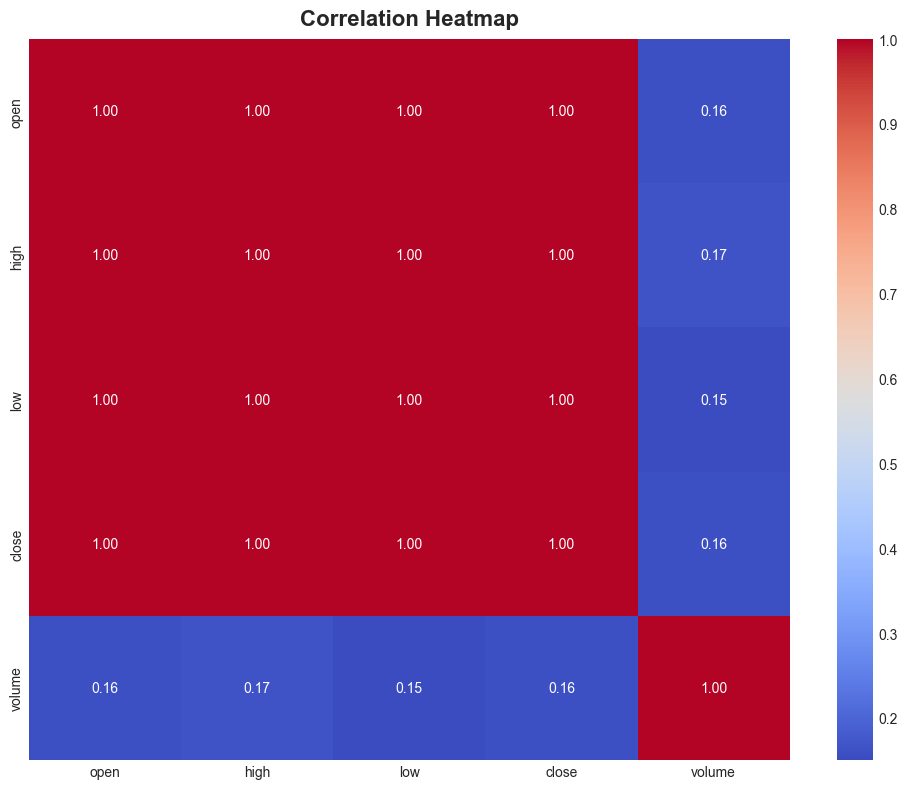

In [417]:
# correlation heatmap
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 8))
correlation_matrix = Trainning_Set.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

    - ## Observe trends, seasonality, cycles and noise.

<Axes: xlabel='day_id'>

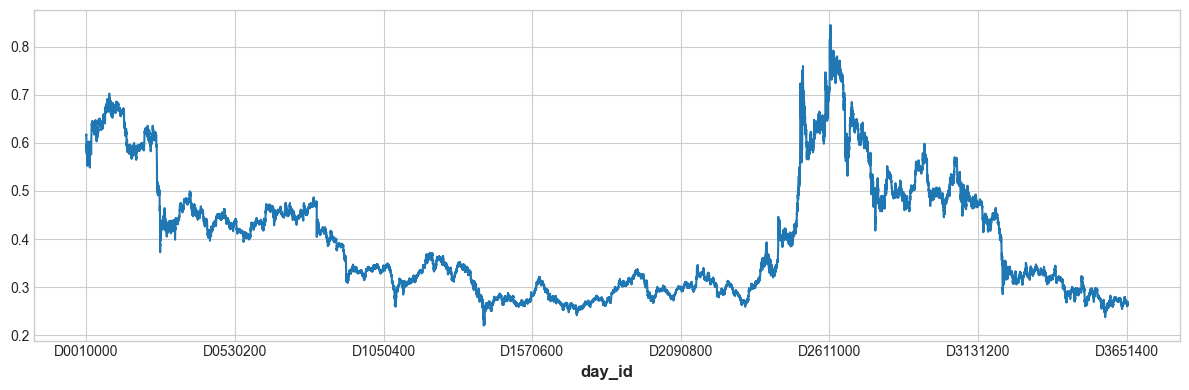

In [418]:
Trainning_Set['close'].plot(figsize=(12, 4))

        - Trend:

<Axes: xlabel='day_id'>

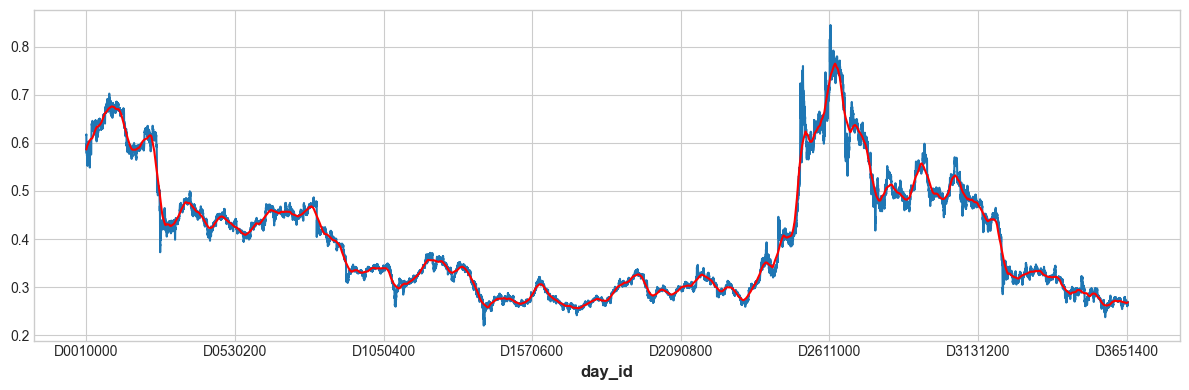

In [419]:
Trainning_Set['trend'] = Trainning_Set['close'].rolling(window=365, center=True, min_periods=183).mean()
Trainning_Set['close'].plot(figsize=(12, 4))
Trainning_Set['trend'].plot(figsize=(12, 4), color='red', label='Trend')


<Axes: xlabel='day_id'>

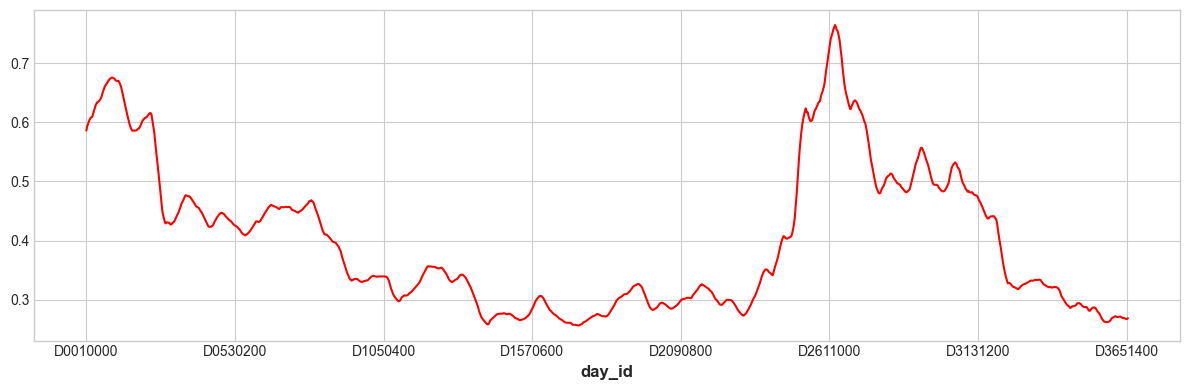

In [420]:
Trainning_Set['trend'].plot(figsize=(12, 4), color='red', label='Trend')

<Axes: xlabel='day_id'>

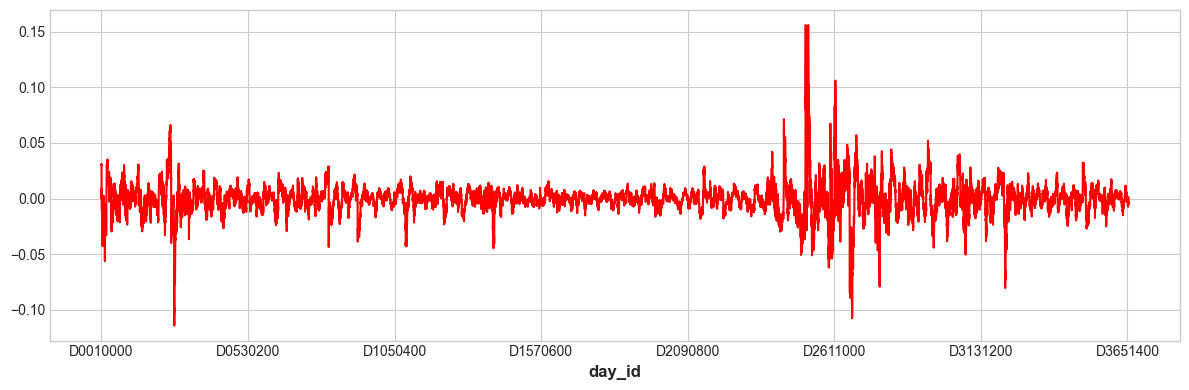

In [421]:
result = Trainning_Set['close'] - Trainning_Set['trend']
result.plot(figsize=(12, 4), color='red', label='Trend')

        - Seasonality:

<Axes: title={'center': 'Seasonal Plot (month/day)'}, xlabel='day', ylabel='close'>

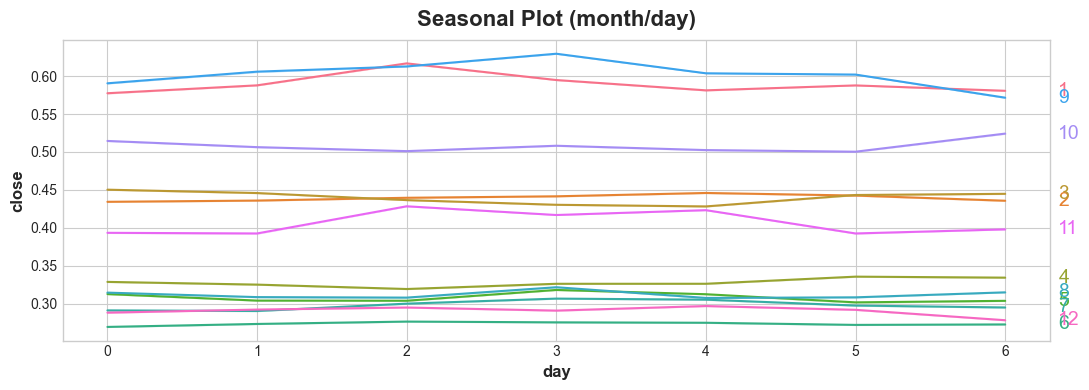

In [422]:


frequency = "15T"  # 15min frequency
start_date = "2023-01-01 00:00"
datetime_index = pd.date_range(start=start_date, periods=len(Trainning_Set), freq="15T")
Trainning_Set.index = datetime_index
X = Trainning_Set[['close']].copy()
iso = X.index.isocalendar()
X["year"] = iso.year
X["month"] = X.index.month
X["week"] = iso.week
X["day"] = X.index.dayofweek
X["hour"] = X.index.hour
X["minute"] = X.index.minute


seasonal_plot(X, y='close', period='month', freq='day')

<Axes: title={'center': 'Seasonal Plot (hour/month)'}, xlabel='month', ylabel='close'>

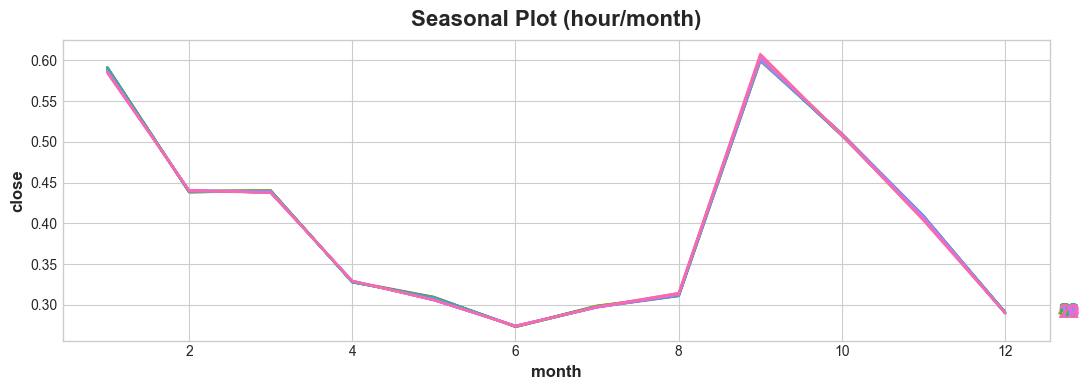

In [423]:
seasonal_plot(X, y='close', period='hour', freq='month')

<Axes: title={'center': 'Seasonal Plot (day/hour)'}, xlabel='hour', ylabel='close'>

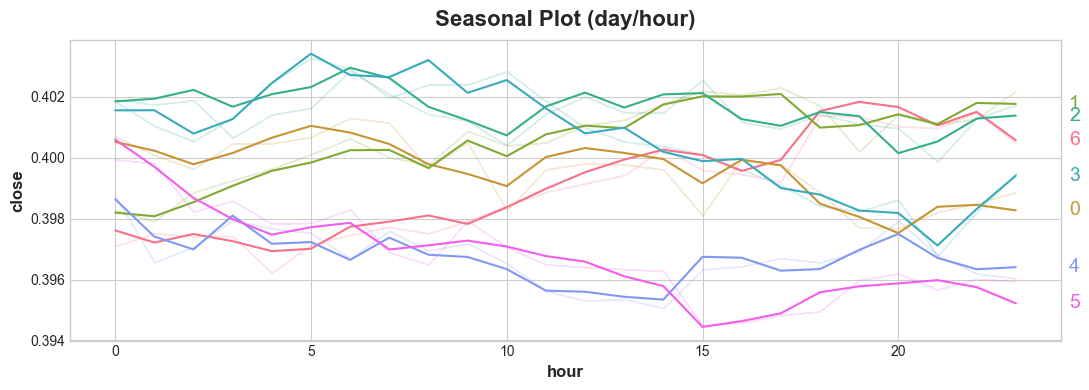

In [424]:
seasonal_plot(X, y='close', period='day', freq='hour')

<Axes: title={'center': 'Seasonal Plot (day/week)'}, xlabel='week', ylabel='close'>

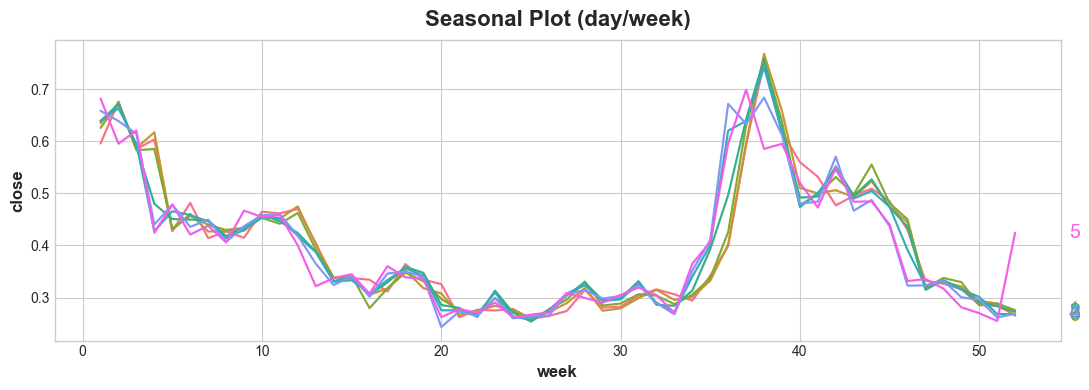

In [425]:
seasonal_plot(X, y='close', period='day', freq='week')

<Axes: title={'center': 'Periodogram'}, ylabel='Variance'>

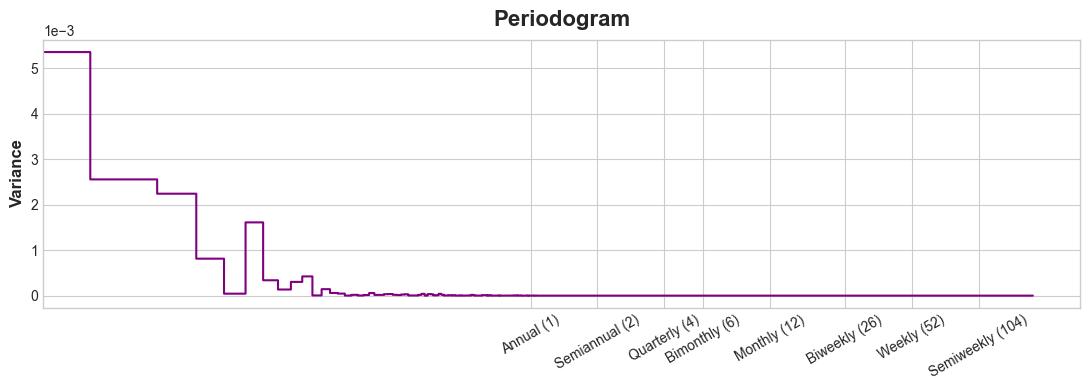

In [426]:
target = Trainning_Set['close'].copy()
plot_periodogram(target)

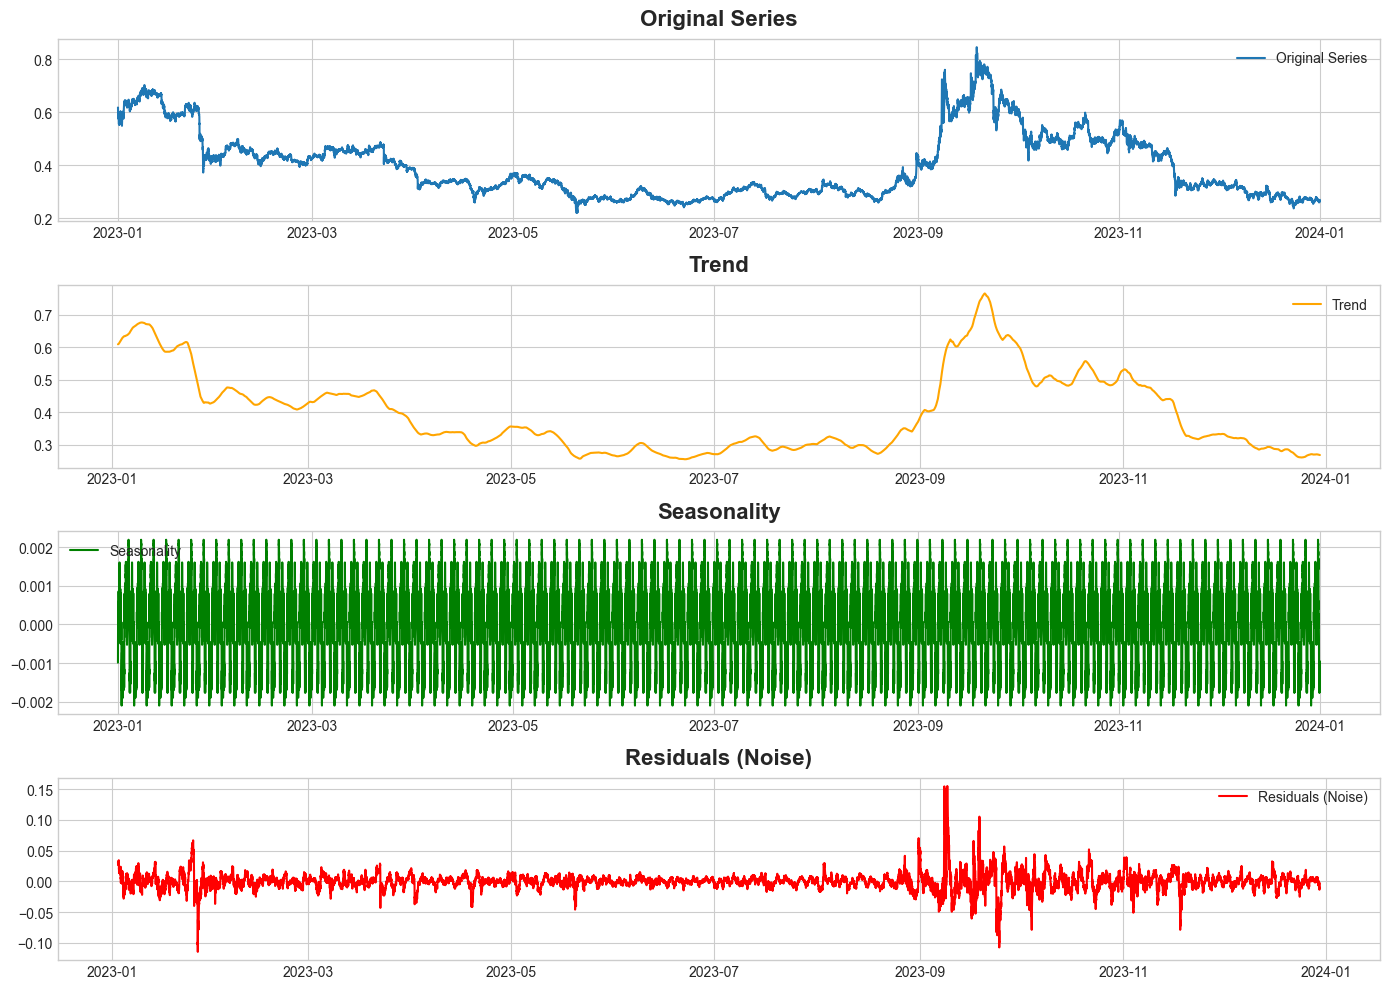

In [427]:
from statsmodels.tsa.seasonal import seasonal_decompose
# Decompose the time series to observe seasonality, trend, and residuals
decomposition = seasonal_decompose(Trainning_Set['close'], model='additive', period=365)

# Plot the decomposed components
plt.figure(figsize=(14, 10))

plt.subplot(4, 1, 1)
plt.plot(Trainning_Set['close'], label='Original Series')
plt.title('Original Series')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(decomposition.trend, label='Trend', color='orange')
plt.title('Trend')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal, label='Seasonality', color='green')
plt.title('Seasonality')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(decomposition.resid, label='Residuals (Noise)', color='red')
plt.title('Residuals (Noise)')
plt.legend()

plt.tight_layout()

# Step 4: Feature Engineering (Lags and Leads)


Final Dataset:
                       close  rolling_mean  rolling_std    lag_1    lag_2  \
2023-01-04 19:00:00  0.61668      0.608951     0.027078  0.62034  0.61966   
2023-01-04 19:15:00  0.61840      0.608956     0.027079  0.61668  0.62034   
2023-01-04 19:30:00  0.62169      0.608967     0.027084  0.61840  0.61668   
2023-01-04 19:45:00  0.62369      0.609000     0.027094  0.62169  0.61840   
2023-01-04 20:00:00  0.61727      0.609035     0.027097  0.62369  0.62169   
...                      ...           ...          ...      ...      ...   
2023-01-09 22:45:00  0.66719      0.664939     0.018669  0.66710  0.66542   
2023-01-09 23:00:00  0.66404      0.665033     0.018578  0.66719  0.66710   
2023-01-09 23:15:00  0.66408      0.665124     0.018491  0.66404  0.66719   
2023-01-09 23:30:00  0.66167      0.665219     0.018383  0.66408  0.66404   
2023-01-09 23:45:00  0.66424      0.665315     0.018286  0.66167  0.66408   

                       lag_3    lag_4   lead_1   lead_2   l

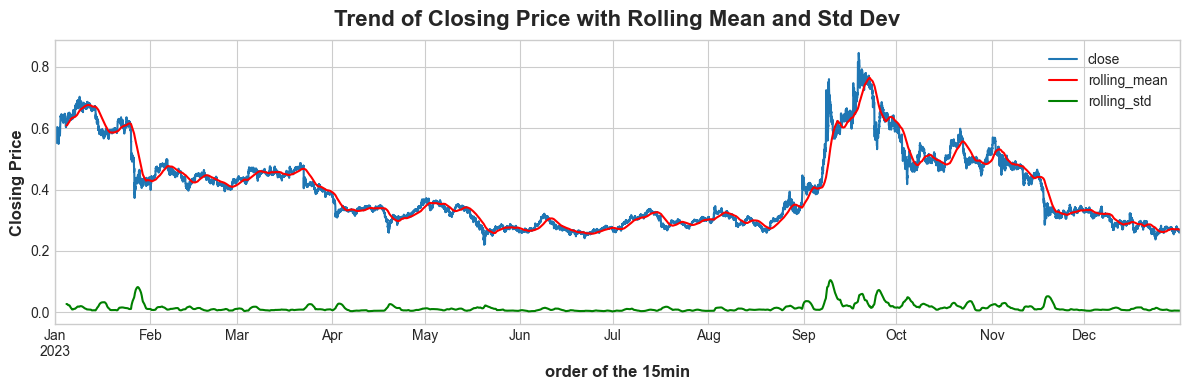

In [428]:
# lag features for close 
lag_features = [1, 2, 3, 4]  
for lag in lag_features:
    Trainning_Set[f'lag_{lag}'] = Trainning_Set['close'].shift(lag)

# lead features for close 
lead_features = [1, 2, 3, 4] 
for lead in lead_features:
    Trainning_Set[f'lead_{lead}'] = Trainning_Set['close'].shift(-lead)

# rolling mean and std
Trainning_Set['rolling_mean'] = Trainning_Set['close'].rolling(window=365).mean()
Trainning_Set['rolling_std'] = Trainning_Set['close'].rolling(window=365).std()
plt.figure(figsize=(14, 7))
Trainning_Set['close'].plot(figsize=(12, 4))
Trainning_Set['rolling_mean'].plot(figsize=(12, 4), color='red', label='rolling_mean')
Trainning_Set['rolling_std'].plot(figsize=(12, 4), color='green', label='rolling_std')



plt.title('Trend of Closing Price with Rolling Mean and Std Dev')
plt.xlabel('order of the 15min')
plt.ylabel('Closing Price')
plt.grid(True)
plt.legend()
plt.tight_layout()

# Combine all the processed features into a final dataset
final_features = ['close', 'rolling_mean', 'rolling_std'] + [f'lag_{lag}' for lag in lag_features]+[f'lead_{lead}' for lead in lead_features]
final_dataset = Trainning_Set[final_features].dropna()

# Display the final dataset
print("\nFinal Dataset:")
print(final_dataset.head(500))

# Save the final dataset to a CSV file for further use
output_path = Data_directory / 'processed_train.csv'
final_dataset.to_csv(output_path, index=False)
print(f"\nFinal dataset saved to {output_path}")

# Step 5: Split dataset for training and validation

In [429]:
from sklearn.model_selection import train_test_split

# Define the target variable and features
X = final_dataset.drop(columns=['close'] )  # Features
y = final_dataset['close']  # Target variable

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X_train
y_train = y_train.loc[X_train.index]
X_val = X_val
y_val = y_val.loc[X_val.index]
# Display the shapes of the resulting datasets
print("\nTraining Features Shape:", X_train.shape)
print("Validation Features Shape:", X_val.shape)
print("Training Target Shape:", y_train.shape)
print("Validation Target Shape:", y_val.shape)


Training Features Shape: (27737, 10)
Validation Features Shape: (6935, 10)
Training Target Shape: (27737,)
Validation Target Shape: (6935,)


# Step 6: Train model and Evaluate RMSE

- Linear regression for trend
- XGBoost for seasonality 

In [430]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
from xgboost import XGBRegressor
# Train a Linear Regression model for trends
trend_model = LinearRegression()
trend_model.fit(X_train, y_train)

# Predict the trend component
trend_predictions = trend_model.predict(X_val)

# Calculate the residuals (seasonality and cycles)
residuals = y_train - trend_model.predict(X_train)

# Train an XGBoost model on the residuals
seasonality_model = XGBRegressor(n_estimators=100, random_state=42)
seasonality_model.fit(X_train, residuals)

# Predict the seasonality and cycles component
seasonality_predictions = seasonality_model.predict(X_val)

# Combine the trend and seasonality predictions (hybrid approach)
hybrid_predictions = trend_predictions + seasonality_predictions

# Evaluate the hybrid model
mse = mean_squared_error(y_val, hybrid_predictions)
rmse = np.sqrt(mse)

print("\nHybrid Model RMSE:", rmse)


Hybrid Model RMSE: 0.001988214929492162


# Step 7: Prepare Test Set for Forcasting

        ## Step 7.1: Add necessary columns

In [431]:
# Forecast future values for the test set
# Since the test set only contains dates, we need to generate features for it

# Create time-based features for the test set
Test_set = Test_set.reset_index(drop=True)
Test_set['day'] = Test_set['day_id'].str[1:4].astype(int)
Test_set['hour'] = Test_set['day_id'].str[4:6].astype(int)
Test_set['minute'] = Test_set['day_id'].str[6:8].astype(int)

# Generate lag features for the test set using only the 'close' column from the training set
for lag in lag_features:
    Test_set[f'lag_{lag}'] = Trainning_Set['close'].shift(lag).iloc[-len(Test_set):].values
# Generate lag features for the test set using only the 'close' column from the training set
for lead in lead_features:
    Test_set[f'lead_{lead}'] = Trainning_Set['close'].shift(-lead).iloc[-len(Test_set):].values
# Generate rolling mean and standard deviation for the test set using only the 'close' column from the training set
Test_set['rolling_mean'] = Trainning_Set['close'].rolling(window=365).mean().iloc[-len(Test_set):].values
Test_set['rolling_std'] = Trainning_Set['close'].rolling(window=365).std().iloc[-len(Test_set):].values
# Ensure the test set has the same features as the training set, excluding columns not present in the test set
feature_columns = ['rolling_mean', 'rolling_std'] + \
                  [f'lag_{lag}' for lag in lag_features] + \
                  [f'lead_{lead}' for lead in lead_features]
test_features = Test_set[['rolling_mean', 'rolling_std'] + [f'lag_{lag}' for lag in lag_features] +[f'lead_{lead}' for lead in lead_features]]

        ## Step 7.2: Impute Missing Values on Test Set due to leads and lags

In [432]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')

# Appliquer l’imputation
test_features = pd.DataFrame(
    imputer.fit_transform(Test_set[feature_columns]),
    columns=feature_columns,
    index=Test_set.index
)

# Step 8: Predict necessary features for forcaseting the closing price

In [433]:
# Predict the trend component for the test set
test_trend_predictions = trend_model.predict(test_features)

# Predict the seasonality and cycles component for the test set
test_seasonality_predictions = seasonality_model.predict(test_features)



# Step 9: Combine features predicted for final forecast and save it to csv


Test forecast saved to Dataset\test_forecast.csv


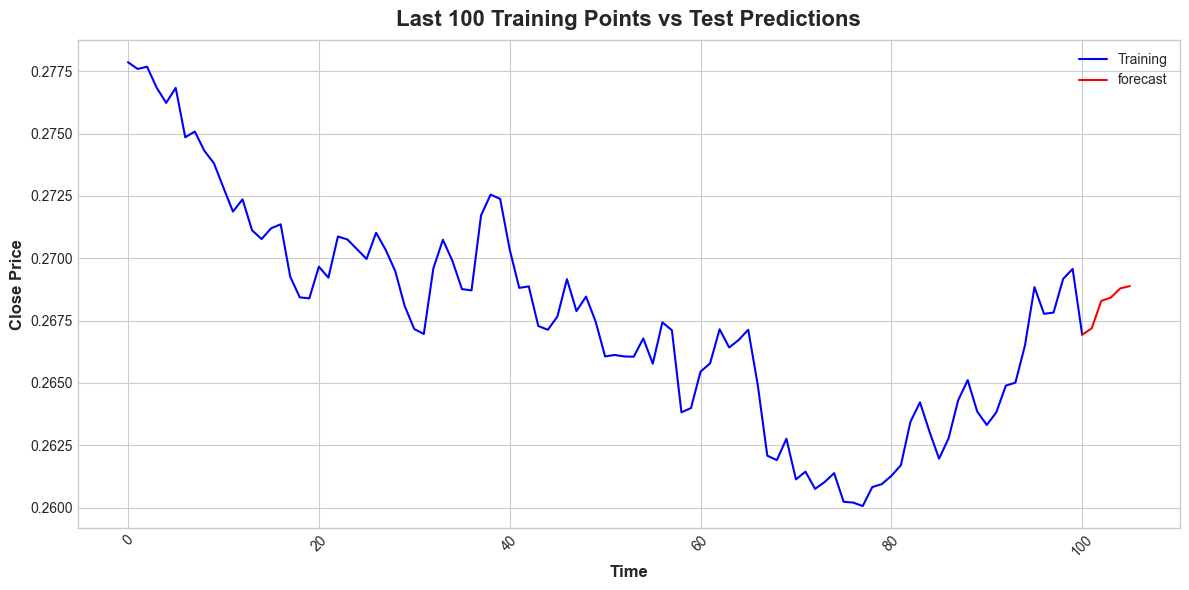

In [434]:
# Combine the trend and seasonality predictions for the test set
test_hybrid_predictions = test_trend_predictions + test_seasonality_predictions
valid_indices = test_features.index
# Save the predictions to a CSV file
test_output_path = Data_directory / 'test_forecast.csv'

# assigne predictions to the test set
Test_set.loc[valid_indices, 'predicted_close'] = test_hybrid_predictions

# save lines with predictions to CSV
Test_set.loc[valid_indices, ['day_id', 'predicted_close']].to_csv(test_output_path, index=False)

print(f"\nTest forecast saved to {test_output_path}")
# Get the last 100 entries from training set
last_10_train = Trainning_Set['close'].iloc[-100:]
last_10_train['rang'] = last_10_train.reset_index().index 
Test_set['rang'] = Test_set.reset_index().index 
plt.figure(figsize=(12, 6))

# Plot training data

all_values = last_10_train.head(100).values.tolist() + test_hybrid_predictions.tolist()
plt.plot(range(101), all_values[:101], color='blue', label='Training')  

plt.plot(range(100, 100 + len(test_hybrid_predictions)), all_values[100:], color='red', label='forecast')
plt.title('Last 100 Training Points vs Test Predictions')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()